#Installing Pyspark

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=9f27149762bbf6e83d240dc04cb70853b273ac6a24590eec49dd1c9c48dfe09d
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create a Spark session
spark = SparkSession.builder.appName('CreditCardFraudDetection').getOrCreate()







In [ ]:
# Import required libraries
#from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

In [ ]:
data_O = spark.read.load('creditcard.csv', 
                          format='csv', 
                          header='true', 
                          inferSchema='true')

type(data_O)

pyspark.sql.dataframe.DataFrame

In [ ]:
classFreq = data_O.groupBy("Class").count()
classFreq.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



#Exploratory Data Analysis

In [ ]:
import pandas as pd
data= data_O.toPandas()
data= data.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = data.loc[data['Class'] == 1]
non_fraud_df = data.loc[data['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.shape

(984, 31)

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


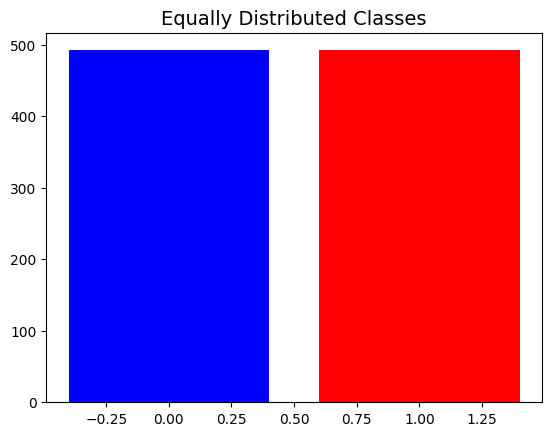

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))


counts = new_df["Class"].value_counts()
plt.bar(counts.index, counts.values, color=['blue', 'red'])
#plt.show()
#sns.barplot('Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

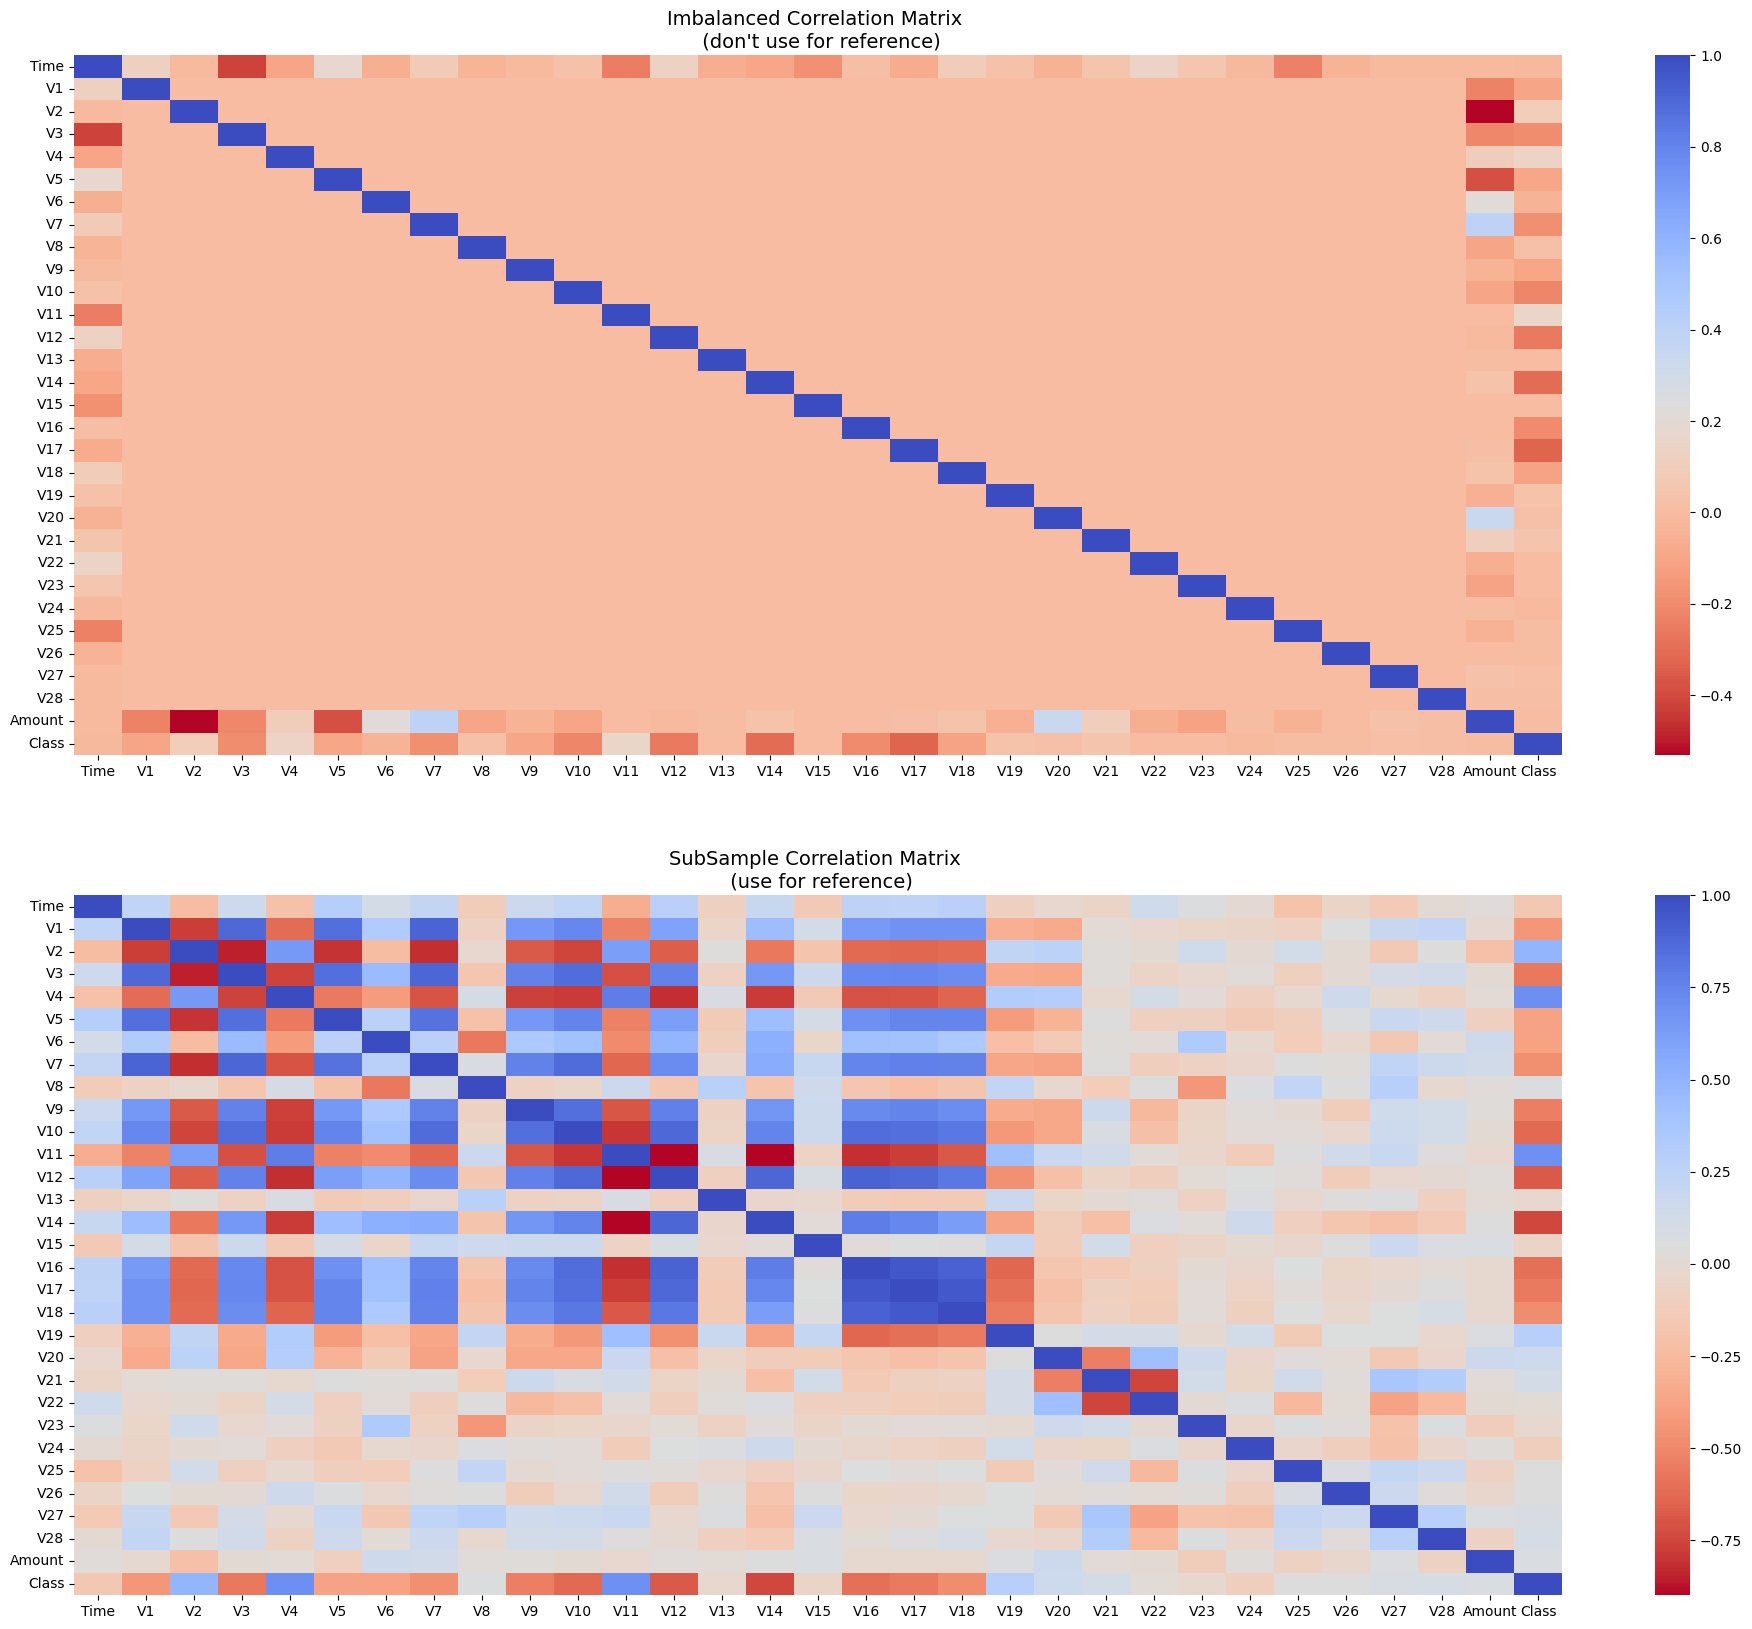

In [ ]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

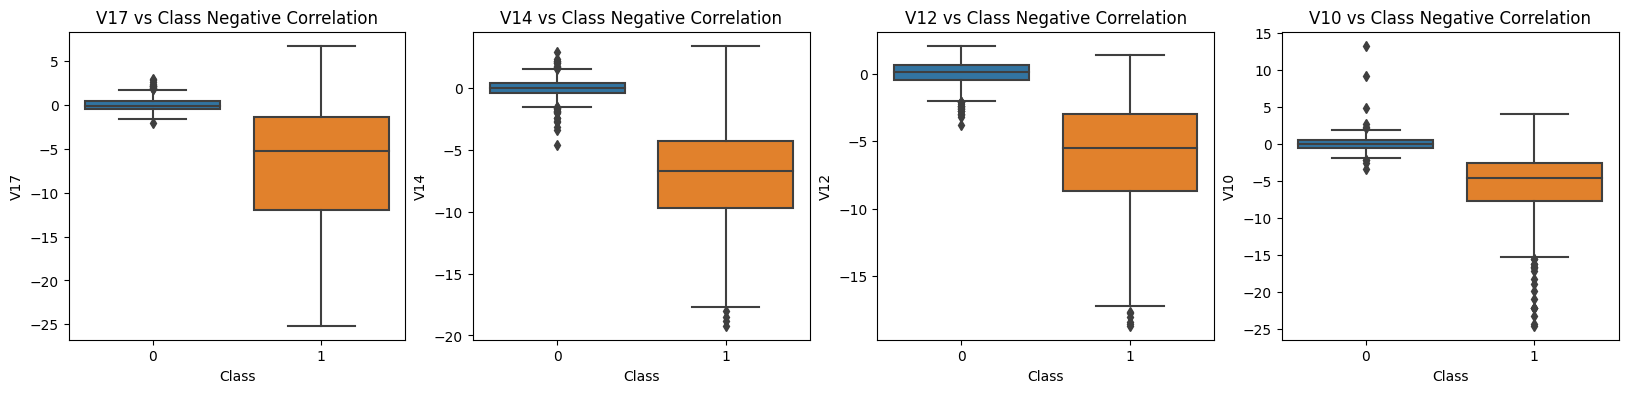

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df,  ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df,  ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

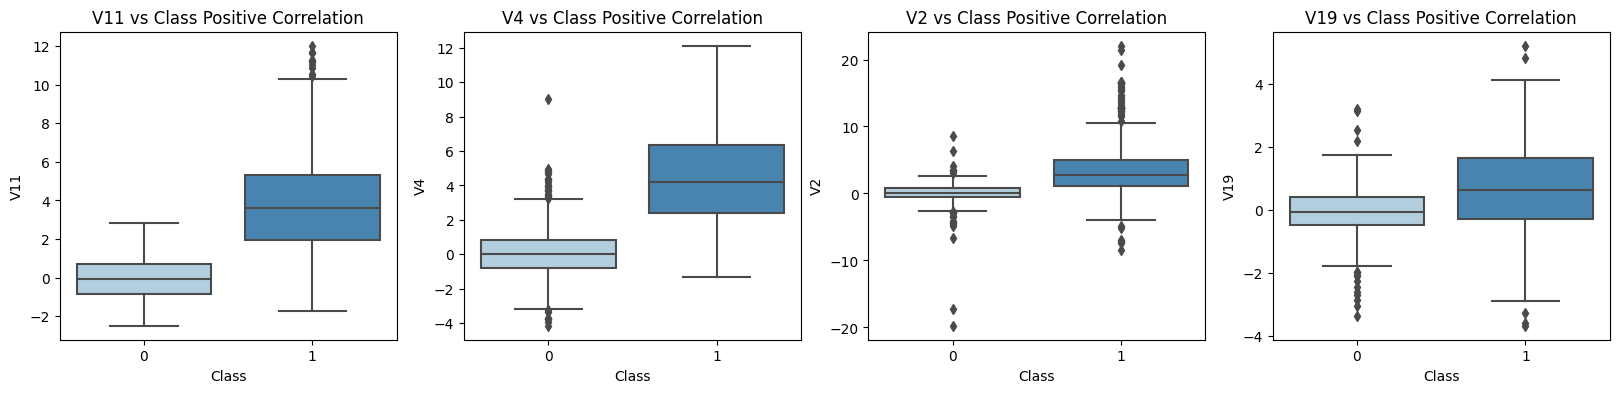

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette="Blues", ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette="Blues", ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette="Blues", ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette="Blues", ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

<ipython-input-16-59787bdd53f6>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
<ipython-input-16-59787bdd53f6>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
<ipython-input-16-59787bdd53f6>:1

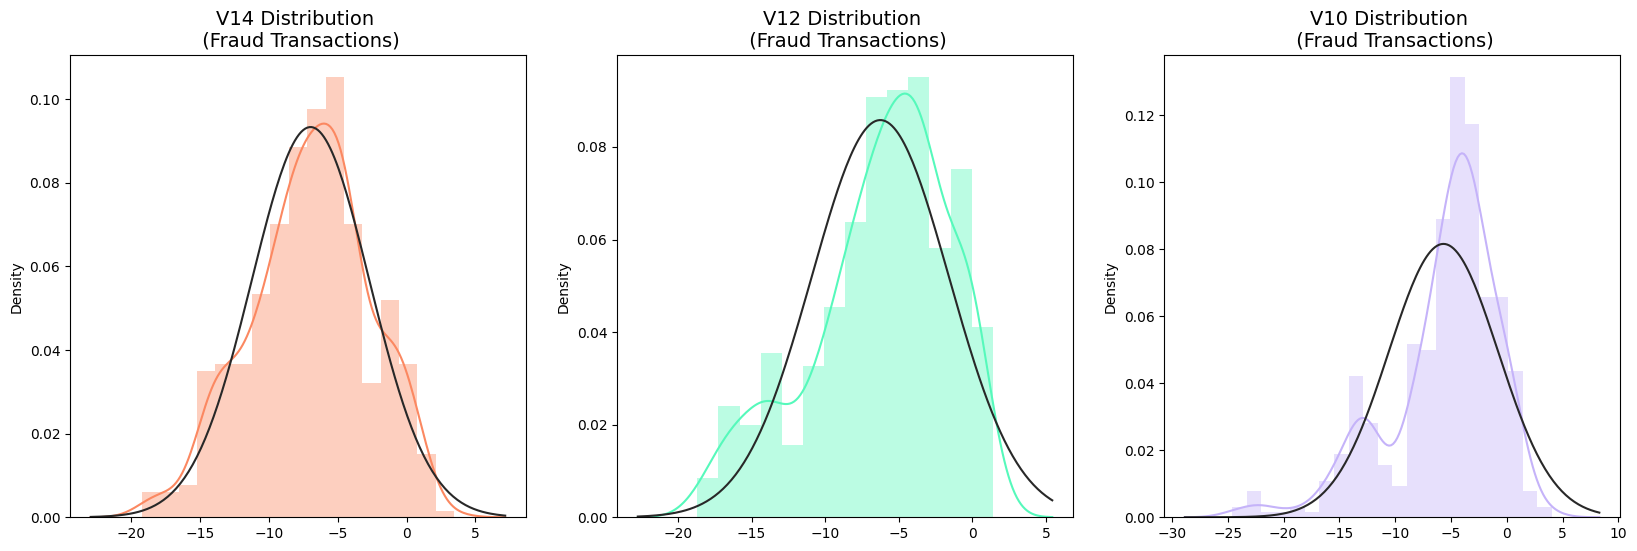

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [ ]:
import numpy as np


# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)


# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25


v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))


type(new_df)

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-19.2143254902614, -18.4937733551053, -18.8220867423816, -18.0499976898594]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.0475965708216, -18.6837146333443, -18.5536970096458, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-15.3460988468775, -15.563791

pandas.core.frame.DataFrame

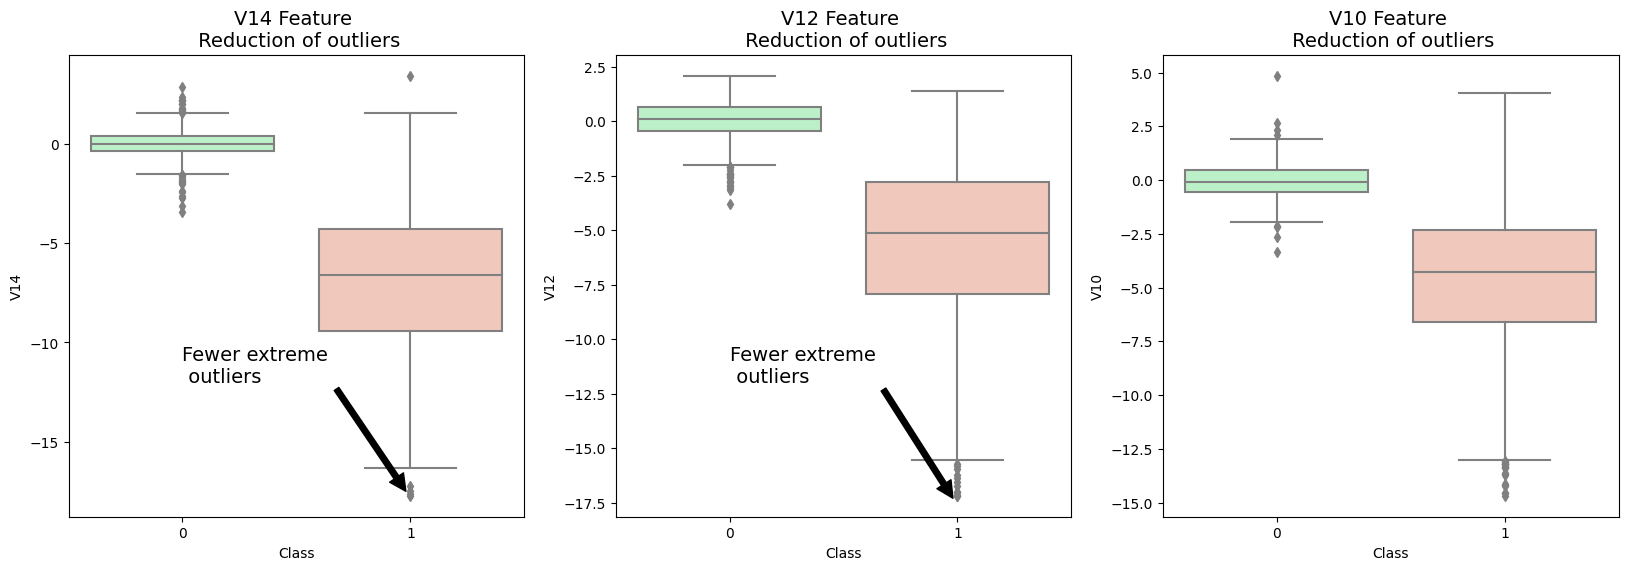

In [ ]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

In [ ]:
dfff = spark.createDataFrame(new_df)

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
win = Window().orderBy('Time')
dfff = dfff.withColumn("idx", row_number().over(win))

In [ ]:
dfff.head()

Row(Time=123.0, V1=0.968783928886267, V2=-0.501798126380266, V3=-1.33355848618811, V4=0.388804289603352, V5=2.0360913833929, V6=3.66171431909762, V7=-0.236794990955591, V8=0.809585634449595, V9=0.154500520085322, V10=-0.0892829546061972, V11=-0.540149745265684, V12=0.24240838382793, V13=-0.195637008724638, V14=0.225998642245616, V15=-0.131979386568109, V16=-0.0811903266986279, V17=-0.506312223566715, V18=-0.0450907029029333, V19=0.314876311175563, V20=0.271697267705073, V21=-0.0910521015614768, V22=-0.561280312108653, V23=-0.260982812072067, V24=1.01770013682126, V25=0.837224846587433, V26=-0.342889063146211, V27=-0.00346740156689819, V28=0.0390037798917582, Amount=160.86, Class=0, idx=1)

#Gradient Boost Tree Classifier

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [ ]:
training_df = dfff.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31]))


training_df = spark.createDataFrame(training_df,["features","label","index"])

training_df.head()

Row(features=DenseVector([123.0, 0.9688, -0.5018, -1.3336, 0.3888, 2.0361, 3.6617, -0.2368, 0.8096, 0.1545, -0.0893, -0.5401, 0.2424, -0.1956, 0.226, -0.132, -0.0812, -0.5063, -0.0451, 0.3149, 0.2717, -0.0911, -0.5613, -0.261, 1.0177, 0.8372, -0.3429, -0.0035, 0.039]), label=0, index=1)

In [ ]:
training_df = training_df.select("index","features","label")

train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)

In [ ]:
train_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  383|
|    1|  371|
+-----+-----+



In [ ]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  107|
|    1|   86|
+-----+-----+



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassificationModel

In [ ]:
gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=8)

In [ ]:
model = gbt.fit(train_data)
predictions = model.transform(test_data)
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  106|
|       1.0|   87|
+----------+-----+



In [ ]:
evaluator = BinaryClassificationEvaluator( metricName='areaUnderROC')
auc_score=evaluator.evaluate(predictions)
#evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Class', metricName='areaUnderROC')
auc_score = evaluator.evaluate(predictions)
print('GBT AUC Score:', auc_score)

GBT AUC Score: 0.9721799608780695


In [ ]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))

In [ ]:
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   81|
|              0|  112|
+---------------+-----+



In [ ]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  107|
|    1|   86|
+-----+-----+



In [ ]:
from pyspark.sql.functions import col

In [ ]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100
FraudPredictionAccuracy

94.18604651162791

In [ ]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

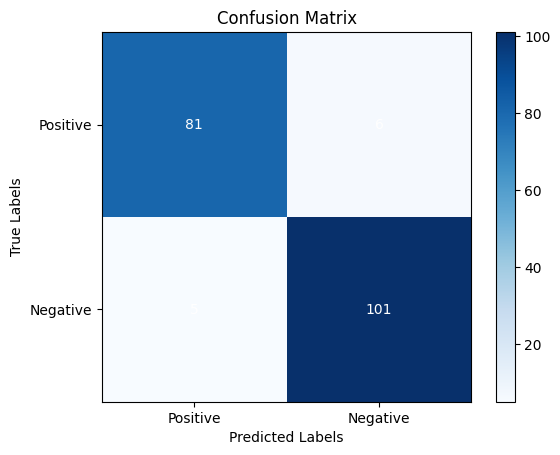

In [ ]:
#from sklearn.metrics import roc_curve, auc
# Create confusion matrix
conf_matrix = np.array([[tp, fp], [fn, tn]])

# Define labels
labels = ['Positive', 'Negative']

# Create heatmap
fig, ax = plt.subplots()
im = ax.imshow(conf_matrix, cmap='Blues')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Add text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, conf_matrix[i, j],
                       ha='center', va='center', color='w')

# Add title and axis labels
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

# Add colorbar legend
cbar = ax.figure.colorbar(im, ax=ax)

# Show plot
plt.show()


In [ ]:
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)
recall=tp/(tp+fn)
precision= tp/(tp+fp)
f1_score=2*((precision*recall)/(precision+recall))
print("Recall: ",recall)
print("Precision: ", precision)
print("F1 score:",f1_score)

True Positive:  81 
True Negative:  101 
False Positive:  6 
False Negative:  5
Recall:  0.9418604651162791
Precision:  0.9310344827586207
F1 score: 0.9364161849710984


#Decision Tree Classifier

In [ ]:
# Load the credit card fraud dataset into a DataFrame
credit_card_data = spark.read.csv('creditcard.csv', header=True, inferSchema=True)
# Create a feature vector by assembling all features into a single vector column
feature_columns = credit_card_data.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data = assembler.transform(credit_card_data)

# Split the dataset into training and test sets
(training_data, test_data) = data.randomSplit([0.7, 0.3], seed=1234)

# Train a decision tree classifier on the training data
decision_tree = DecisionTreeClassifier(labelCol='Class', featuresCol='features', maxDepth=5)
dt_model = decision_tree.fit(training_data)

In [ ]:
# Evaluate the decision tree model on the test data
predictions = dt_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol='Class')
dt_auc = evaluator.evaluate(predictions)

print('Decision Tree AUC:', dt_auc)


Decision Tree AUC: 0.7671278800080057


In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np


In [ ]:
# Calculate precision and recall for the decision tree model
y_true = predictions.select(['Class']).collect()
y_scores = predictions.select(['probability']).collect()
y_scores = [x[0][1] for x in y_scores]
precision, recall, _ = precision_recall_curve(y_true, y_scores)
dt_pr_auc = auc(recall, precision)
#print("Precision:",precision)
#print("Recall:",recall)
dt_precision = np.round(precision[np.argmax(recall >= 0.9)], 3)
dt_recall = np.round(recall[np.argmax(recall >= 0.9)], 3)
print('Decision Tree Precision:', dt_precision)
print('Decision Tree Recall:', dt_recall)

Decision Tree Precision: 0.002
Decision Tree Recall: 1.0


In [ ]:
# Calculate the F1 score for the decision tree classifier model
from sklearn.metrics import f1_score
dt_f1 = f1_score(y_true, [1 if x >= 0.5 else 0 for x in y_scores])
print('Decision Tree F1 Score:', dt_f1)

Decision Tree F1 Score: 0.7768595041322314


#Logistic Regression

In [ ]:
# Train a logistic regression model on the training data
logistic_reg = LogisticRegression(labelCol='Class', featuresCol='features')
lr_model = logistic_reg.fit(training_data)

# Evaluate the logistic regression model on the test data
predictions = lr_model.transform(test_data)
lr_auc = evaluator.evaluate(predictions)

print('Logistic Regression AUC:', lr_auc)

Logistic Regression AUC: 0.9724348397925897


In [ ]:
# Calculate precision and recall for the logistic regression model
y_true = predictions.select(['Class']).collect()
y_scores = predictions.select(['probability']).collect()
y_scores = [x[0][1] for x in y_scores]
precision, recall, _ = precision_recall_curve(y_true, y_scores)
lr_pr_auc = auc(recall, precision)
lr_precision = np.round(precision[np.argmax(recall >= 0.9)], 3)
lr_recall = np.round(recall[np.argmax(recall >= 0.9)], 3)
print('Logistic Regression Precision:', lr_precision)
print('Logistic Regression Recall:', lr_recall)

Logistic Regression Precision: 0.002
Logistic Regression Recall: 1.0


In [ ]:
# Calculate the F1 score for the logistic regression model
from sklearn.metrics import f1_score
lr_f1 = f1_score(y_true, [1 if x >= 0.5 else 0 for x in y_scores])
print('Logistic Regression F1 Score:', lr_f1)

Logistic Regression F1 Score: 0.6869565217391305


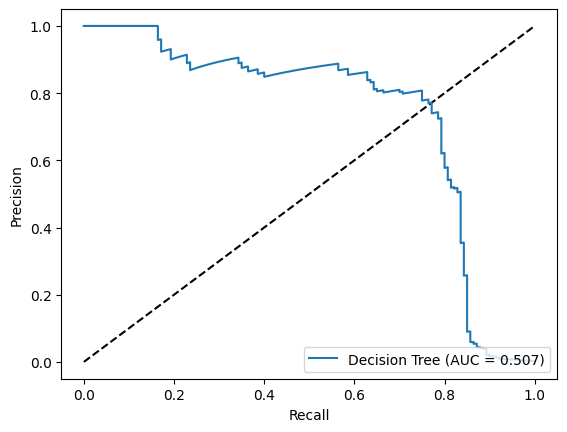

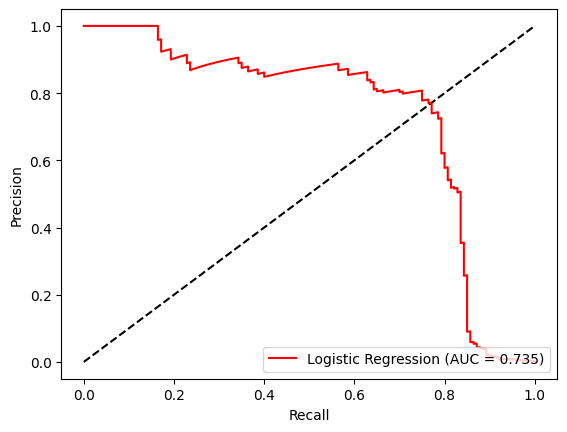

In [ ]:
# Plot the AUC curves
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall, precision, label='Decision Tree (AUC = {:.3f})'.format(dt_pr_auc))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()


plt.plot([0, 1], [0, 1], 'k--')

plt.plot(recall, precision, label='Logistic Regression (AUC = {:.3f})'.format(lr_pr_auc),color="red")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()


# Stop the Spark session
spark.stop()